# population-inference
notebook for running vectorised inference over a population of hares or emus

In [1]:
#stock imports
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import pickle
import scipy
import os
##plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import corner

#script imports
from scripts import prior_funcs, utils

from scripts.pitchfuncs_ultra_pca import emulator
from scripts.pitchfuncs_ultra_pca import ultra_ns_vector_nice
from scripts.pitchfuncs_ultra_pca import ultra_ns_vector_simpleslice
from scripts.pitchfuncs_ultra_pca import ultra_ns_vector_slice
from scripts.pitchfuncs_ultra_pca import ultra_ns_vector_walk


os.environ["CUDA_VISIBLE_DEVICES"]="0"

physical_devices = tf.config.list_physical_devices("GPU") 

tf.config.experimental.set_memory_growth(physical_devices[0], True)

gpu0usage = tf.config.experimental.get_memory_info("GPU:0")["current"]

2024-06-19 16:24:28.629837: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-19 16:24:28.629868: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-19 16:24:28.630876: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-19 16:24:28.636754: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-19 16:24:29.178006: W tensorflow/compiler/tf2

## import neural network

In [2]:
pitchfork_name = "nu6-40_elu_nonorm_feh"
pitchfork = emulator(pitchfork_name)

with open("pitchfork/" +pitchfork_name+ ".pkl", 'rb') as fp:
     pitchfork_info = pickle.load(fp)

pitchfork_ranges = pitchfork_info['parameter_ranges']

initial_mass range: [min = 0.8, max = 1.2]
initial_Zinit range: [min = 0.003869061466818601, max = 0.0389797119014747]
initial_Yinit range: [min = 0.24, max = 0.32]
initial_MLT range: [min = 1.7, max = 2.5]
star_age range: [min = 0.029664111540787196, max = 13.999973871651315]


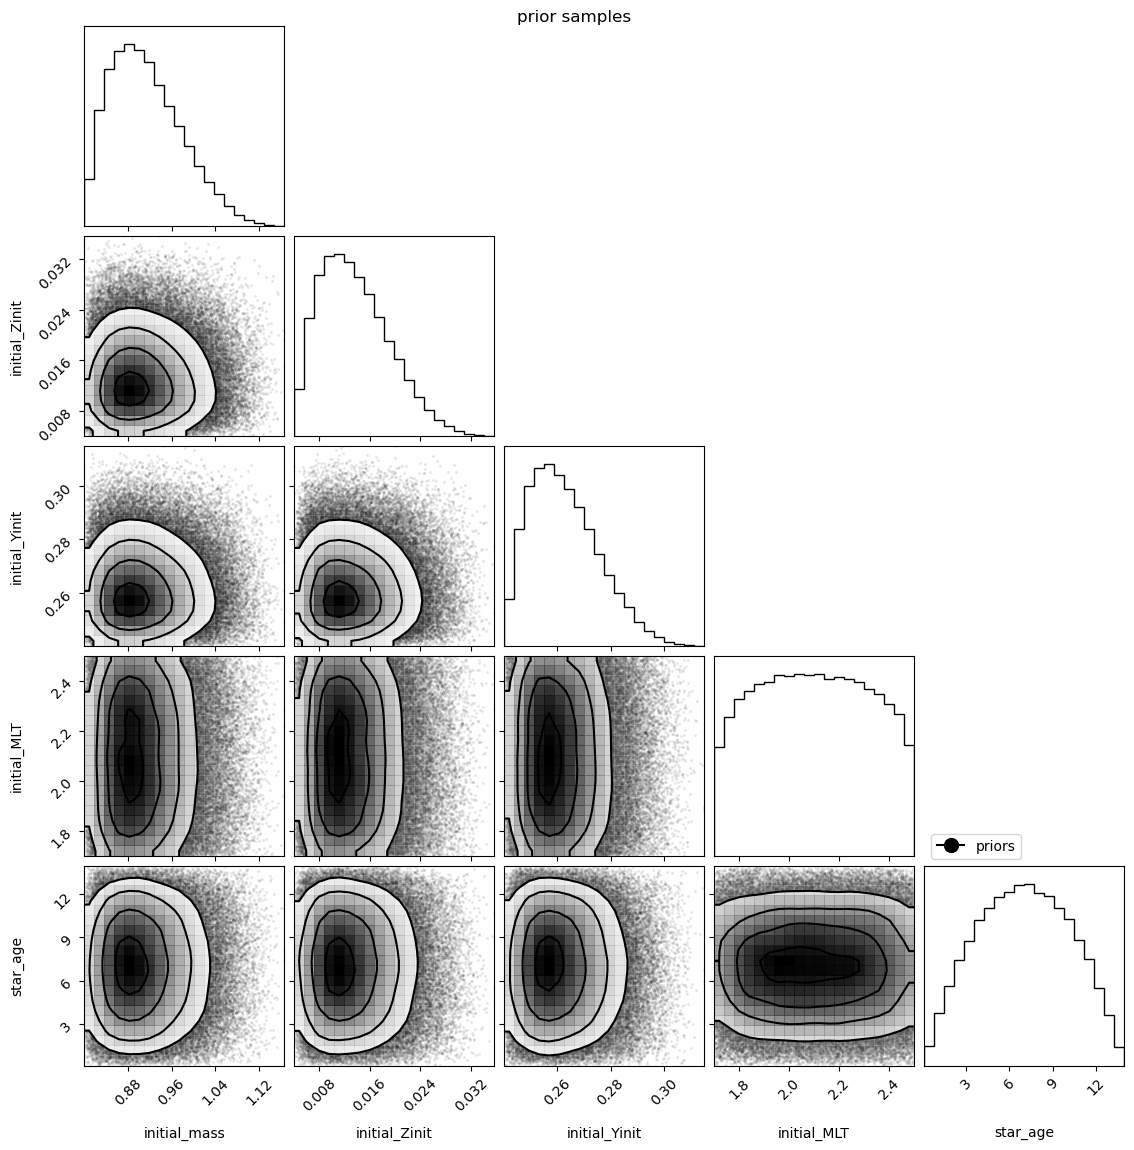

In [3]:
labels = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']

mass_prior = prior_funcs.custom_beta_prior(0.8, 1.2, a=2, b=5)

Zinit_prior = prior_funcs.custom_beta_prior(0.004, 0.038, a=2, b=5)

Yinit_prior = prior_funcs.custom_beta_prior(0.24, 0.32, a=2, b=5)

MLT_prior = prior_funcs.custom_beta_prior(1.7, 2.5, a=1.2, b=1.2)

age_prior = prior_funcs.custom_beta_prior(0.03, 14, a=2, b=2)


priors = [mass_prior, Zinit_prior, Yinit_prior, MLT_prior, age_prior]

size = 100000
plot_prior_samples = np.array([prior.rvs(size=size) for prior in priors])
legend_labels = []
corner_color = 'black'
corner.corner(plot_prior_samples.T, labels = labels, color=corner_color, hist_kwargs={'density':True}, smooth=True);
legend_labels = legend_labels + [Line2D([0], [0], marker='o', color =corner_color, markerfacecolor = corner_color, markersize=10, label='priors')]
plt.suptitle('prior samples')
plt.legend(handles=legend_labels, bbox_to_anchor=(0., 1.0, 1., .0), loc=0)
plt.show()

In [6]:
%%time

with open("pitchfork/emulator_cov.pkl", 'rb') as fp:
     sigma_nn = pickle.load(fp)

ndraw_min=2**14
ndraw_max=2**16

obs_idx = 0
for hare_idx in range(1):
    path = f'form/hare{hare_idx}/obs{obs_idx}/'
    hare_observed = pd.read_json(path+f'obs{obs_idx}.json')
    hare_uncs = pd.read_json(path+'uncs.json')
    hare_uncs_array = hare_uncs.values[0]

    n_min = int(hare_uncs.drop(['calc_effective_T', 'luminosity', 'star_feh'], axis=1).columns[0].replace('nu_0_',''))
    n_max = int(hare_uncs.drop(['calc_effective_T', 'luminosity', 'star_feh'], axis=1).columns[-1].replace('nu_0_',''))

    sigma_nn_mask = np.zeros(len(sigma_nn), dtype=bool)
    sigma_nn_mask[:3] = True
    sigma_nn_mask[n_min-3:n_max-2] = True

    sigma_nn_cropped = sigma_nn[:,sigma_nn_mask][sigma_nn_mask,:]

    sigma_obs = (hare_uncs_array*hare_uncs_array)*(np.identity(len(hare_uncs_array)))

    sigma = sigma_nn_cropped + sigma_obs

    sigma_inv = np.linalg.inv(sigma)

    _, log_sigma_det = np.linalg.slogdet(sigma)
    
    outputs = ['calc_effective_T', 'luminosity', 'star_feh'] + [f'nu_0_{i}' for i in range(n_min,n_max+1)]
    
    sampler = ultra_ns_vector_simpleslice(priors=priors, observed_vals=hare_observed[outputs].values[0], pitchfork=pitchfork,log_sigma_det=log_sigma_det, sigma_inv=sigma_inv, n_min=n_min, n_max=n_max, logl_scale=1)
    results = sampler(ndraw_min, ndraw_max, nsteps=10, popsize=400).run(min_num_live_points=400, frac_remain=.01)
    with open(path+'/samples.pkl', 'wb') as fp:
        pickle.dump(results, fp, protocol=pickle.HIGHEST_PROTOCOL)

    sampler.cleanup()
    del results

[ultranest] Sampling 400 live points from prior ...


2024-06-19 16:20:00.711038: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


[ultranest] Explored until L=-1e+01   [-13.5608..-13.5608]*| it/evals=6080/710800 eff=0.8559% N=400    0    0 0  
[ultranest] Likelihood function evaluations: 710800
[ultranest]   logZ = -24.19 +- 0.1248
[ultranest] Effective samples strategy satisfied (ESS = 2052.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.12 tail:0.01 total:0.13 required:<0.50
[ultranest] done iterating.
CPU times: user 19.6 s, sys: 244 ms, total: 19.8 s
Wall time: 19.4 s


In [10]:
%%time

with open("pitchfork/emulator_cov.pkl", 'rb') as fp:
     sigma_nn = pickle.load(fp)

ndraw_min=2**20
ndraw_max=2**20

obs_idx = 0
for hare_idx in range(1):
    path = f'form/hare{hare_idx}/obs{obs_idx}/'
    hare_observed = pd.read_json(path+f'obs{obs_idx}.json')
    hare_uncs = pd.read_json(path+'uncs.json')
    hare_uncs_array = hare_uncs.values[0]

    n_min = int(hare_uncs.drop(['calc_effective_T', 'luminosity', 'star_feh'], axis=1).columns[0].replace('nu_0_',''))
    n_max = int(hare_uncs.drop(['calc_effective_T', 'luminosity', 'star_feh'], axis=1).columns[-1].replace('nu_0_',''))

    sigma_nn_mask = np.zeros(len(sigma_nn), dtype=bool)
    sigma_nn_mask[:3] = True
    sigma_nn_mask[n_min-3:n_max-2] = True

    sigma_nn_cropped = sigma_nn[:,sigma_nn_mask][sigma_nn_mask,:]

    sigma_obs = (hare_uncs_array*hare_uncs_array)*(np.identity(len(hare_uncs_array)))

    sigma = sigma_nn_cropped + sigma_obs

    sigma_inv = np.linalg.inv(sigma)

    _, log_sigma_det = np.linalg.slogdet(sigma)
    
    outputs = ['calc_effective_T', 'luminosity', 'star_feh'] + [f'nu_0_{i}' for i in range(n_min,n_max+1)]
    
    sampler = ultra_ns_vector_slice(priors=priors, observed_vals=hare_observed[outputs].values[0], pitchfork=pitchfork,log_sigma_det=log_sigma_det, sigma_inv=sigma_inv, n_min=n_min, n_max=n_max, logl_scale=1)
    results = sampler(ndraw_min, ndraw_max, nsteps=10, popsize=100).run(min_num_live_points=400, frac_remain=.01)
    with open(path+'/samples.pkl', 'wb') as fp:
        pickle.dump(results, fp, protocol=pickle.HIGHEST_PROTOCOL)

    sampler.cleanup()
    del results

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-13.6407..-13.6402]*| it/evals=5941/601701 eff=0.9880% N=400         0    
[ultranest] Likelihood function evaluations: 601701
[ultranest]   logZ = -23.84 +- 0.08489
[ultranest] Effective samples strategy satisfied (ESS = 2045.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.09, need <0.5)
[ultranest]   logZ error budget: single: 0.14 bs:0.08 tail:0.01 total:0.09 required:<0.50
[ultranest] done iterating.
CPU times: user 2min 56s, sys: 2.08 s, total: 2min 59s
Wall time: 2min 51s


In [ ]:
%%time

with open("pitchfork/emulator_cov.pkl", 'rb') as fp:
     sigma_nn = pickle.load(fp)

ndraw_min=2**20
ndraw_max=2**20

obs_idx = 0
for hare_idx in range(1):
    path = f'form/hare{hare_idx}/obs{obs_idx}/'
    hare_observed = pd.read_json(path+f'obs{obs_idx}.json')
    hare_uncs = pd.read_json(path+'uncs.json')
    hare_uncs_array = hare_uncs.values[0]

    n_min = int(hare_uncs.drop(['calc_effective_T', 'luminosity', 'star_feh'], axis=1).columns[0].replace('nu_0_',''))
    n_max = int(hare_uncs.drop(['calc_effective_T', 'luminosity', 'star_feh'], axis=1).columns[-1].replace('nu_0_',''))

    sigma_nn_mask = np.zeros(len(sigma_nn), dtype=bool)
    sigma_nn_mask[:3] = True
    sigma_nn_mask[n_min-3:n_max-2] = True

    sigma_nn_cropped = sigma_nn[:,sigma_nn_mask][sigma_nn_mask,:]

    sigma_obs = (hare_uncs_array*hare_uncs_array)*(np.identity(len(hare_uncs_array)))

    sigma = sigma_nn_cropped + sigma_obs

    sigma_inv = np.linalg.inv(sigma)

    _, log_sigma_det = np.linalg.slogdet(sigma)
    
    outputs = ['calc_effective_T', 'luminosity', 'star_feh'] + [f'nu_0_{i}' for i in range(n_min,n_max+1)]
    
    sampler = ultra_ns_vector_nice(priors=priors, observed_vals=hare_observed[outputs].values[0], pitchfork=pitchfork,log_sigma_det=log_sigma_det, sigma_inv=sigma_inv, n_min=n_min, n_max=n_max, logl_scale=1)
    results = sampler(ndraw_min, ndraw_max).run(min_num_live_points=400, frac_remain=.1)
    with open(path+'/samples.pkl', 'wb') as fp:
        pickle.dump(results, fp, protocol=pickle.HIGHEST_PROTOCOL)

    sampler.cleanup()
    del results

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-13.9967..-13.9959]*| it/evals=5110/1491784 eff=0.3426% N=400         0 00 
[ultranest] Likelihood function evaluations: 1491784
